In [1]:
!pip install wandb -qqq
import wandb
wandb.login(key="9086993130a56abc5cd780b691a69c2618757f73")

     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 145 kB 72.4 MB/s 
     |████████████████████████████████| 181 kB 28.6 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
!pip uninstall opencv-python -y -q
!pip install opencv-python==4.1.2.30 -q
!pip install albumentations --upgrade -q

!pip uninstall opencv-python -y -q
!pip install opencv-python==4.1.2.30 -q
!pip install albumentations --upgrade -q
import albumentations as A
A.__version__

     |████████████████████████████████| 28.3 MB 65.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 102 kB 9.6 MB/s 
     |████████████████████████████████| 47.8 MB 83 kB/s 


'1.1.0'

In [3]:
!nvidia-smi

Thu Jun  2 21:31:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
import os
import numpy as np
import pandas as pd
from glob import glob
from natsort import natsorted

In [5]:
!unzip -qq /content/drive/MyDrive/4-1_Capstone/CapstoneDataset/images_concatenate.zip -d /content/capstone_images
capstone_images = natsorted(glob(os.path.join("/content/capstone_images", '*')))

capstone_label_df = pd.read_csv("/content/drive/MyDrive/4-1_Capstone/CapstoneDataset/Capstone_labels.csv")

SAMPLES = 500
os.system("unzip -qq /content/drive/MyDrive/4-1_Capstone/AI_HubDataset/images" + str(SAMPLES) + ".zip -d /content/aihub_images")
aihub_images = natsorted(glob(os.path.join("/content/aihub_images/images" + str(SAMPLES), '*')))

aihub_label_df = pd.read_csv("/content/aihub_images/AI_Label_" + str(SAMPLES)  +".csv")

images = capstone_images + aihub_images
label_df = pd.concat([capstone_label_df, aihub_label_df]).fillna(0.).reset_index(drop = True)

In [6]:
# GAN
!unzip -qq /content/drive/MyDrive/4-1_Capstone/AI_HubDataset/gen_all.zip -d /content/gen_all

N_CLASSES = 72

gen_images = os.listdir("/content/gen_all")

gen_y = [int(f.split('_')[0]) for f in gen_images]
gen_y = np.eye(N_CLASSES)[gen_y]

gen_images = [os.path.join("/content/gen_all", f) for f in gen_images]

# train_images = np.concatenate([train_images, gen_images])
# train_y      = np.concatenate([train_y, gen_y])

images = np.array(images)
label_df = label_df.values

images   = np.concatenate([images, gen_images])
label_df = np.concatenate([label_df, gen_y])

In [7]:
# train_test_split
argmax_classes = []
# for label in label_df.values:
for label in label_df:
    if label.sum() == 1:    argmax_classes.append(label.argmax())
    else:                   argmax_classes.append(4) # 3과 4가 동시에 존재하면 4 데이터가 적으므로 4에 포함시킴

# # len(argmax_classes)
# from sklearn.model_selection import train_test_split
# train_i, val_i, _, _ = train_test_split(list(range(len(label_df))), argmax_classes, stratify=argmax_classes, random_state=0)

# train_images = np.array(images)[train_i]
# val_images   = np.array(images)[val_i]

# train_y = label_df.values[train_i]
# val_y   = label_df.values[val_i]

In [8]:
from torch.utils.data import Dataset
from PIL import Image
import cv2

class MyDataset(Dataset):

    def __init__(self, dataset_info, transform=None, split=None):        
        
        self.split = split
        self.transform = transform

        self.img_dirs, self.y = dataset_info

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):        
        image = cv2.imread(self.img_dirs[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Augment an image
        transformed = self.transform(image=image)
        image = transformed["image"]
        y = self.y[idx]

        return image, y

# import torchvision.transforms as T
# !pip install timm -q
# import timm
# from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# tf = T.Compose([
#     # T.Resize(256, interpolation=3),
#     # T.CenterCrop(224),
#     T.Resize(224, interpolation=3),
#     T.ToTensor(),
#     # T.RandomRotation(degrees=(-180, 180)),
#     # T.RandomHorizontalFlip(p=0.5),
#     # T.RandomVerticalFlip(p=0.5), # Rotation을 넣는 순간 Flip은 한개만 수행하면 되며, H-Flip이 V-Flip보다 빠르다.
#     # T.ColorJitter(brightness=.5, contrast=.5),
#     T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
# ])


import albumentations as A
import albumentations.pytorch as A_

train_tf = A.Compose([
    A.Resize(224, 224),
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    A_.transforms.ToTensorV2(),
])

tf = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    A_.transforms.ToTensorV2(),

])



In [9]:
%cd /content/drive/MyDrive/4-1_Capstone
from utils import get_crop_mask

crop_mask = get_crop_mask()
crop_mask = torch.Tensor(crop_mask).cuda()
crop_mask

/content/drive/MyDrive/4-1_Capstone


tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [11]:
!pip install timm -q
N_CLASSES = 72
import torch
import timm
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torchvision
%config InlineBackend.figure_format = 'retina'

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

!pip install wandb -qqq
import wandb
wandb.login(key="9086993130a56abc5cd780b691a69c2618757f73")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calc_macro_f1(preds, GT):
    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)    
    return f1_score(GT, preds_sigmoid, average = 'macro', zero_division = 0)

# method
def train(model, epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3, dataset_info = None):
    nb_epochs = epoch

    model = model.to(device)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    if      optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    elif    optimizer == 'RMSprop':
        optimizer = torch.optim.RMSProp(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion = torch.nn.BCEWithLogitsLoss().to(device)

    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4, nb_epochs*2//4, nb_epochs*3//4], gamma=0.5)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3)       

    train_info, val_info = dataset_info

    train_loader = DataLoader(MyDataset(train_info, train_tf, split='TRAIN'),
                            batch_size=batch_size,
                            shuffle=True,
                            # drop_last=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)


    validation_loader = DataLoader(MyDataset(val_info, tf, split='VALIDATION'),
                            batch_size=batch_size,
                            shuffle=False,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)

    import warnings
    warnings.filterwarnings('ignore')

    train_losses = []
    val_losses = []
    train_macro_f1 = []
    val_macro_f1 = []
    from tqdm import tqdm
    for epoch in tqdm(range(nb_epochs)):

        losses = 0
        preds = []                
        GTs    = []
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            H = model(X)    
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
            # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
            preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
            GTs.extend((Y.detach().cpu().numpy()* 1).tolist())
            loss = criterion(H, Y)        
            losses += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = losses / len(GTs)
        train_losses.append(train_loss)
        
        train_f1 = calc_macro_f1(preds, GTs)
        train_macro_f1.append(train_f1)

        scheduler.step()
        # print("train_loss = ", train_loss)

        losses = 0
        preds = []                
        model.eval()
        with torch.no_grad():
            for X, Y in validation_loader:
                X = X.to(device)
                Y = Y.to(device)

                H = model(X)
                H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
                # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
                preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
                loss = criterion(H, Y)

                losses += loss.item()
        val_loss = losses / len(val_info[1])
        val_losses.append(val_loss)
        # print("val_loss = ", val_loss)

        val_f1 = calc_macro_f1(preds, val_info[1])
        val_macro_f1.append(val_f1)

        print(f"EPOCH {epoch} : TRAIN_LOSS = {train_loss:.4f}  VAL_LOSS = {val_loss:.4f}  TRAIN_F1 = {train_f1:.3f} VAL_F1 = {val_f1:.3f}")
        # 🐝 2️⃣ Log metrics from your script to W&B
        wandb.log({"train-loss": train_loss, "validation-loss": val_loss, "train-f1": train_f1, "val-f1": val_f1})

    # Mark the run as finished
    wandb.finish()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_macro_f1, label='train')
    plt.plot(val_macro_f1, label='val')
    plt.title('macro_f1')
    plt.legend()

    plt.show()


def test(model, val_dataset_info, batch_size = 32):

    test_loader = DataLoader(MyDataset(val_dataset_info, tf, split='VALIDATION'),
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=False,
                        pin_memory=True,
                        num_workers=4)

    preds = []

    model.eval()
    with torch.no_grad():
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)

            H = model(X)
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)

            preds.extend(H.detach().cpu().numpy().tolist())
    from sklearn.metrics import multilabel_confusion_matrix, classification_report

    # confusion_matrix = multilabel_confusion_matrix(val_y, (preds_numpy > 0).astype(float))

    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)

    cr = classification_report(val_dataset_info[1], preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(72)])
    print(cr) # note_that support means count

    return preds

def preds_analysis(preds):
    preds = np.array(preds)

    from collections import Counter
    import matplotlib.pyplot as plt
    for cls in range(len(label_df.columns)):
        plt.figure(figsize=(20,3))
        Actual_y = cls
        x = [str(n) for n in range(len(label_df.columns))]
        y = (preds[val_y[:, Actual_y] == 1] > 0).astype(int).sum(0)

        plt.bar(x, y)
        plt.title(f"Actual_y = {Actual_y}")

        for i in range(len(y)):
            plt.annotate(y[i], (x[i], y[i]), ha = 'center', va = 'bottom')

        plt.show()

from sklearn.model_selection import StratifiedKFold

sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

K_train_x = []
K_test_x = []

K_train_y = []
K_test_y = []

for train_idx , test_idx in sfk.split(images , np.array(argmax_classes)):
    K_train_x_i = np.array(images)[train_idx]
    K_test_x_i = np.array(images)[test_idx]

    K_train_y_i  = label_df[train_idx, :]
    K_test_y_i  = label_df[test_idx, :]

    K_train_x.append(K_train_x_i)
    K_test_x.append(K_test_x_i)

    K_train_y.append(K_train_y_i)
    K_test_y.append(K_test_y_i)
    
def run_K_fold(model = 'E', epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3, memo=None, K = 5):

    architecture = 'EfficientNet_B0' if model == 'E' else 'DeiT'

    for k in range(K):
        # 🐝 1️⃣ Start a new run to track this script
        wandb.init(
            # Set the project where this run will be logged
            project="debug",
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name = f"{memo}_{k}", 
            # Track hyperparameters and run metadata
            config={
            "architecture": architecture,
            "epochs": epoch,
            "optimizer": optimizer,
            "learning_rate": lr,
            })
        
        from torch.nn import Linear
        N_CLASSES = 72
        if model == 'E':
            model = timm.create_model(model_name = 'efficientnet_b0', pretrained=True)
            model.classifier = Linear(in_features=1280, out_features=N_CLASSES, bias=True)

        if model == 'D':
            model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
            model.head = Linear(in_features=768, out_features=N_CLASSES, bias=True)
        
        train_dataset_info = (K_train_x[k], K_train_y[k])
        val_dataset_info = (K_test_x[k], K_test_y[k])
        dataset_info = (train_dataset_info, val_dataset_info)

        train(model, epoch, batch_size, optimizer, lr, dataset_info)
        preds = test(model, val_dataset_info)
        torch.save(model.state_dict(), f"/content/{k}th_model.pth")

     |████████████████████████████████| 431 kB 8.4 MB/s 


wandb: Currently logged in as: bjjun970. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1. EfficientNet B0

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 10%|█         | 1/10 [03:25<30:47, 205.27s/it]

EPOCH 0 : TRAIN_LOSS = 0.0207  VAL_LOSS = 0.0206  TRAIN_F1 = 0.918 VAL_F1 = 0.957


 20%|██        | 2/10 [06:37<26:19, 197.40s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.964 VAL_F1 = 0.968


 30%|███       | 3/10 [09:49<22:45, 195.03s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.980 VAL_F1 = 0.981


 40%|████      | 4/10 [13:01<19:24, 194.04s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.956 VAL_F1 = 0.972


 50%|█████     | 5/10 [16:13<16:06, 193.34s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.974 VAL_F1 = 0.979


 60%|██████    | 6/10 [19:25<12:51, 192.82s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.984 VAL_F1 = 0.983


 70%|███████   | 7/10 [22:40<09:40, 193.52s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.965 VAL_F1 = 0.975


 80%|████████  | 8/10 [25:54<06:26, 193.45s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.977 VAL_F1 = 0.979


 90%|█████████ | 9/10 [29:05<03:12, 192.95s/it]

EPOCH 8 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.986 VAL_F1 = 0.985


100%|██████████| 10/10 [32:17<00:00, 193.71s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.970 VAL_F1 = 0.976


train-f1,▁▆▇▅▇█▆▇█▆
train-loss,█▄▂▄▂▁▃▂▁▃
val-f1,▁▄▇▅▆█▆▇█▆
validation-loss,█▅▂▄▂▁▃▂▁▃
train-f1,0.96953
train-loss,0.02061
val-f1,0.97603
validation-loss,0.02059


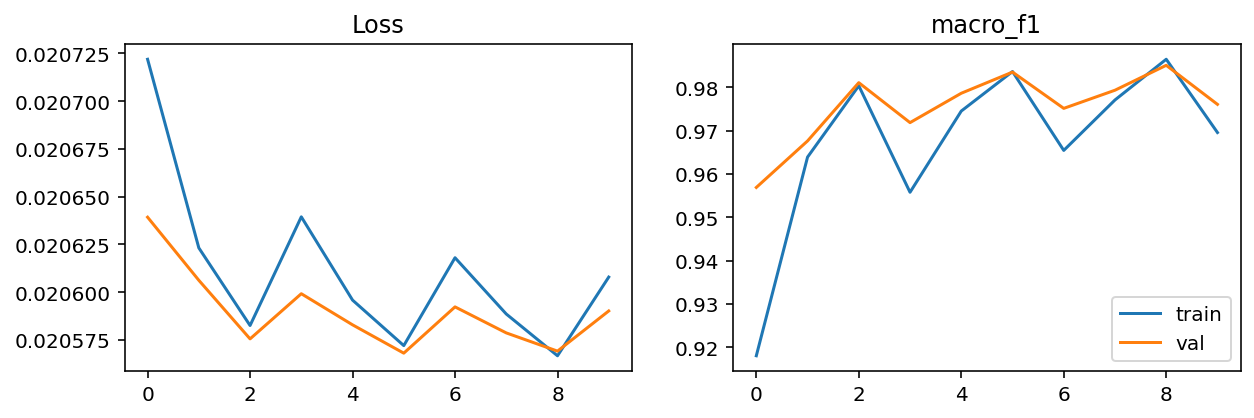

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       605
           1       0.97      1.00      0.99       111
           2       1.00      0.99      1.00       249
           3       0.98      0.97      0.97       578
           4       0.98      0.93      0.96       165
           5       0.99      0.99      0.99       336
           6       0.94      1.00      0.97       218
           7       0.94      0.93      0.94       239
           8       0.99      0.98      0.98       330
           9       1.00      1.00      1.00       289
          10       0.98      1.00      0.99       114
          11       0.95      0.99      0.97       226
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00        65
          14       1.00      0.99      0.99       100
          15       0.99      1.00      1.00       100
          16       0.99      0.99      0.99       100
          17       0.99    

 10%|█         | 1/10 [03:08<28:18, 188.71s/it]

EPOCH 0 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.972 VAL_F1 = 0.982


 20%|██        | 2/10 [06:16<25:07, 188.45s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.980 VAL_F1 = 0.986


 30%|███       | 3/10 [09:25<22:00, 188.65s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.988 VAL_F1 = 0.988


 40%|████      | 4/10 [12:34<18:51, 188.60s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.975 VAL_F1 = 0.980


 50%|█████     | 5/10 [15:42<15:42, 188.59s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.983 VAL_F1 = 0.986


 60%|██████    | 6/10 [18:51<12:33, 188.49s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.989 VAL_F1 = 0.988


 70%|███████   | 7/10 [21:59<09:25, 188.39s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.977 VAL_F1 = 0.979


 80%|████████  | 8/10 [25:08<06:17, 188.72s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.984 VAL_F1 = 0.981


 90%|█████████ | 9/10 [28:17<03:08, 188.73s/it]

EPOCH 8 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.990 VAL_F1 = 0.988


100%|██████████| 10/10 [31:26<00:00, 188.64s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.978 VAL_F1 = 0.978


train-f1,▁▄▇▂▅█▃▆█▃
train-loss,█▅▂▇▄▁▇▃▁▆
val-f1,▃▆█▂▆█▂▃█▁
validation-loss,▄▃▁▅▃▂▅▄▂█
train-f1,0.97797
train-loss,0.02059
val-f1,0.97848
validation-loss,0.02059


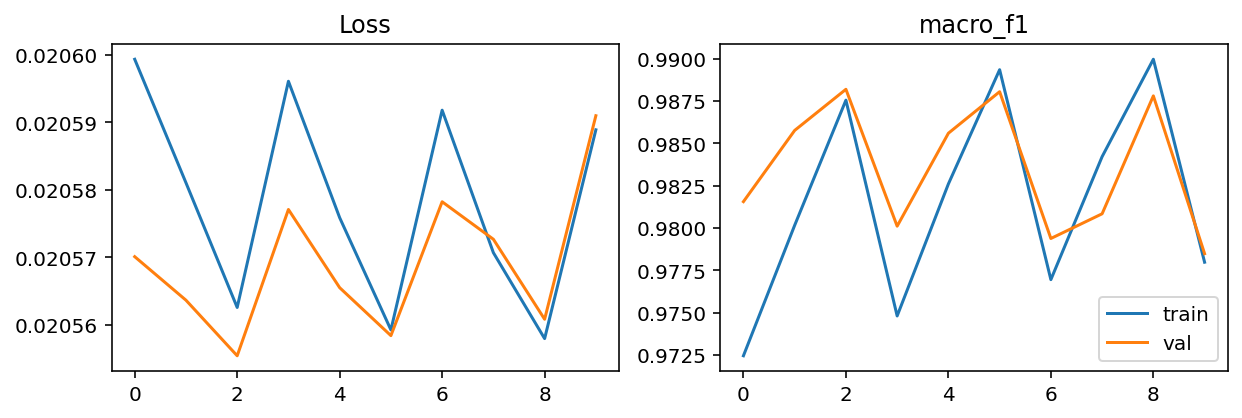

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       605
           1       0.99      0.99      0.99       111
           2       0.99      1.00      0.99       249
           3       0.96      0.99      0.97       580
           4       1.00      0.85      0.92       165
           5       1.00      0.91      0.95       336
           6       0.96      1.00      0.98       218
           7       0.99      0.95      0.97       239
           8       0.99      0.90      0.94       330
           9       1.00      1.00      1.00       289
          10       1.00      0.99      1.00       113
          11       0.85      1.00      0.92       227
          12       1.00      0.99      0.99       100
          13       1.00      1.00      1.00        65
          14       0.98      1.00      0.99       100
          15       1.00      0.99      0.99       100
          16       0.99      1.00      1.00       100
          17       0.99    

 10%|█         | 1/10 [03:09<28:21, 189.00s/it]

EPOCH 0 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.979 VAL_F1 = 0.986


 20%|██        | 2/10 [06:20<25:22, 190.26s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.984 VAL_F1 = 0.987


 30%|███       | 3/10 [09:31<22:16, 190.96s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.991 VAL_F1 = 0.991


 40%|████      | 4/10 [12:42<19:04, 190.81s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.980 VAL_F1 = 0.983


 50%|█████     | 5/10 [15:53<15:54, 190.89s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.986 VAL_F1 = 0.984


 60%|██████    | 6/10 [19:04<12:43, 190.88s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.990 VAL_F1 = 0.990


 70%|███████   | 7/10 [22:15<09:33, 191.10s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.980 VAL_F1 = 0.983


 80%|████████  | 8/10 [25:27<06:22, 191.18s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.986 VAL_F1 = 0.985


 90%|█████████ | 9/10 [28:40<03:11, 191.69s/it]

EPOCH 8 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.992 VAL_F1 = 0.990


100%|██████████| 10/10 [31:52<00:00, 191.22s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.981 VAL_F1 = 0.983


train-f1,▁▄▇▁▄▇▁▅█▂
train-loss,█▅▂█▄▂▇▄▁▇
val-f1,▃▄█▁▂▇▁▃▆▁
validation-loss,▅▄▁█▆▂█▅▃█
train-f1,0.98116
train-loss,0.02058
val-f1,0.98345
validation-loss,0.02058


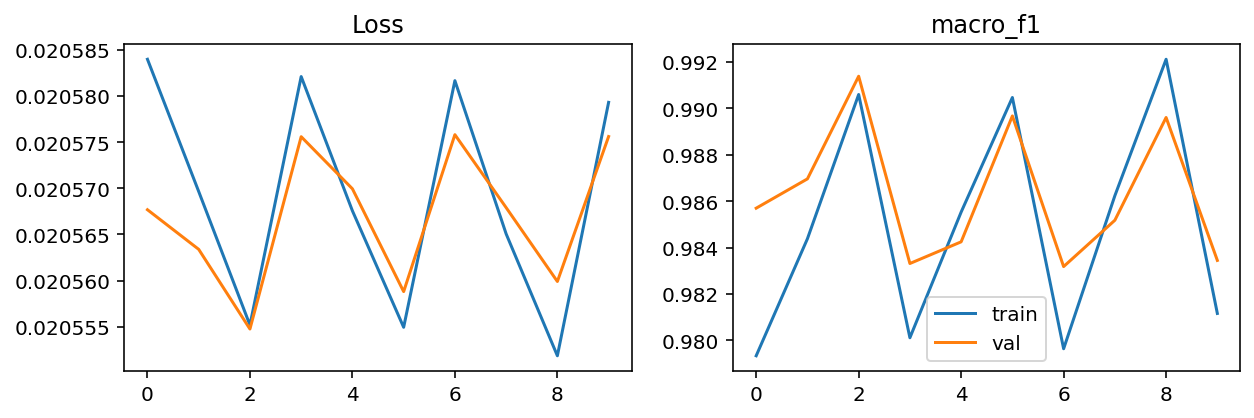

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       605
           1       0.99      1.00      1.00       111
           2       1.00      1.00      1.00       248
           3       0.98      0.97      0.97       582
           4       0.96      0.95      0.95       166
           5       1.00      1.00      1.00       335
           6       0.94      1.00      0.97       218
           7       0.99      0.93      0.96       239
           8       1.00      0.98      0.99       331
           9       1.00      1.00      1.00       289
          10       1.00      0.99      1.00       113
          11       0.98      1.00      0.99       226
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00        65
          14       0.99      0.99      0.99       100
          15       0.97      1.00      0.99       100
          16       1.00      1.00      1.00       100
          17       1.00    

 10%|█         | 1/10 [03:13<28:58, 193.17s/it]

EPOCH 0 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.983 VAL_F1 = 0.990


 20%|██        | 2/10 [06:26<25:43, 192.98s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.988 VAL_F1 = 0.988


 30%|███       | 3/10 [09:40<22:35, 193.57s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0205  TRAIN_F1 = 0.992 VAL_F1 = 0.993


 40%|████      | 4/10 [12:53<19:19, 193.31s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.982 VAL_F1 = 0.987


 50%|█████     | 5/10 [16:07<16:08, 193.66s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.988 VAL_F1 = 0.990


 60%|██████    | 6/10 [19:22<12:56, 194.01s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.993 VAL_F1 = 0.992


 70%|███████   | 7/10 [22:38<09:44, 194.73s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.983 VAL_F1 = 0.985


 80%|████████  | 8/10 [25:54<06:30, 195.04s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.988 VAL_F1 = 0.986


 90%|█████████ | 9/10 [29:08<03:14, 194.78s/it]

EPOCH 8 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.993 VAL_F1 = 0.991


100%|██████████| 10/10 [32:22<00:00, 194.21s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.985 VAL_F1 = 0.985


train-f1,▁▅▇▁▅█▁▅█▃
train-loss,█▄▁█▄▁█▄▁▆
val-f1,▅▄█▃▆▇▁▂▇▁
validation-loss,▅▄▁▇▃▂█▆▂█
train-f1,0.98504
train-loss,0.02057
val-f1,0.9847
validation-loss,0.02057


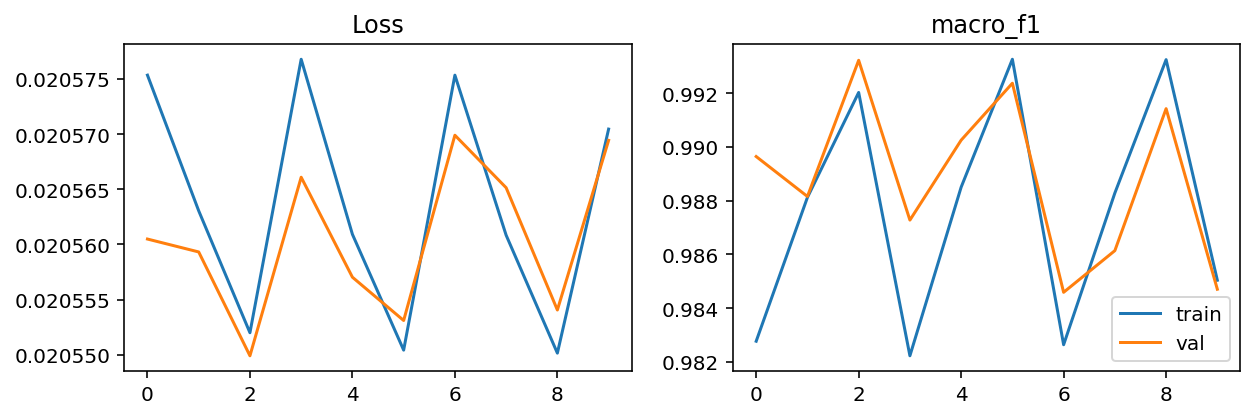

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       605
           1       0.99      0.99      0.99       111
           2       1.00      0.97      0.99       248
           3       0.99      0.97      0.98       571
           4       0.97      0.95      0.96       166
           5       0.99      1.00      1.00       335
           6       0.99      1.00      0.99       218
           7       0.99      0.99      0.99       239
           8       0.98      1.00      0.99       331
           9       1.00      1.00      1.00       289
          10       1.00      1.00      1.00       113
          11       1.00      0.95      0.98       226
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00        65
          14       1.00      0.99      0.99       100
          15       1.00      1.00      1.00       100
          16       1.00      1.00      1.00       100
          17       0.99    

 10%|█         | 1/10 [03:13<29:05, 193.91s/it]

EPOCH 0 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.984 VAL_F1 = 0.990


 20%|██        | 2/10 [06:28<25:56, 194.56s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.989 VAL_F1 = 0.991


 30%|███       | 3/10 [09:43<22:40, 194.41s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.993 VAL_F1 = 0.994


 40%|████      | 4/10 [12:58<19:29, 194.91s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.984 VAL_F1 = 0.987


 50%|█████     | 5/10 [16:12<16:13, 194.62s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.989 VAL_F1 = 0.989


 60%|██████    | 6/10 [19:28<12:59, 194.92s/it]

EPOCH 5 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.994 VAL_F1 = 0.993


 70%|███████   | 7/10 [22:42<09:44, 194.75s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.985 VAL_F1 = 0.985


 80%|████████  | 8/10 [25:56<06:28, 194.26s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.990 VAL_F1 = 0.990


 90%|█████████ | 9/10 [29:09<03:13, 193.96s/it]

EPOCH 8 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.994 VAL_F1 = 0.992


100%|██████████| 10/10 [32:23<00:00, 194.35s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.986 VAL_F1 = 0.987


train-f1,▁▄▇▁▅█▁▅█▂
train-loss,█▅▂█▅▂█▄▁▇
val-f1,▅▆█▂▄▇▁▅▆▃
validation-loss,▅▃▁▇▄▂█▅▃▇
train-f1,0.98587
train-loss,0.02057
val-f1,0.98675
validation-loss,0.02057


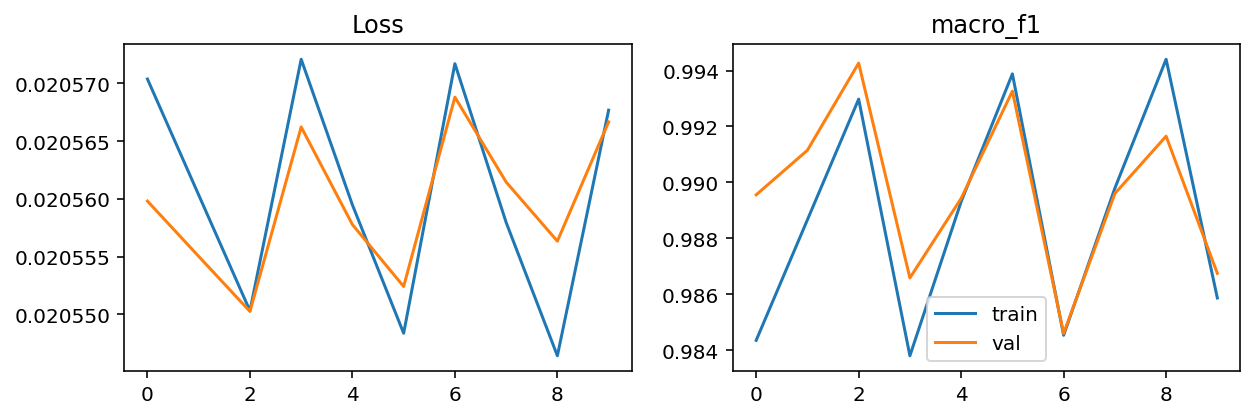

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       605
           1       1.00      0.99      1.00       110
           2       1.00      1.00      1.00       249
           3       0.98      0.97      0.98       578
           4       0.93      0.96      0.95       165
           5       0.99      1.00      1.00       336
           6       1.00      0.97      0.99       218
           7       0.98      1.00      0.99       239
           8       1.00      0.99      1.00       330
           9       1.00      1.00      1.00       289
          10       1.00      1.00      1.00       114
          11       1.00      1.00      1.00       226
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00        65
          14       1.00      0.98      0.99       100
          15       0.98      1.00      0.99       100
          16       1.00      1.00      1.00       100
          17       1.00    

In [12]:
run_K_fold(model = 'E', epoch = 10, batch_size = 32, optimizer='AdamW', memo = "Ensemble_Augmentation_GAN")

  3%|▎         | 1/30 [04:41<2:16:16, 281.95s/it]

EPOCH 0 : TRAIN_LOSS = 0.0207  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.930


  7%|▋         | 2/30 [09:17<2:09:56, 278.44s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.943


 10%|█         | 3/30 [13:50<2:04:07, 275.84s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.964


 13%|█▎        | 4/30 [18:22<1:58:49, 274.20s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.928


 17%|█▋        | 5/30 [22:55<1:54:04, 273.76s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.016 VAL_F1 = 0.951


 20%|██        | 6/30 [27:31<1:49:48, 274.53s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.961


 23%|██▎       | 7/30 [32:40<1:49:37, 285.97s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.945


 27%|██▋       | 8/30 [37:57<1:48:22, 295.57s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.953


 30%|███       | 9/30 [43:00<1:44:20, 298.10s/it]

EPOCH 8 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.964


 33%|███▎      | 10/30 [47:40<1:37:28, 292.43s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.947


 37%|███▋      | 11/30 [52:18<1:31:11, 287.97s/it]

EPOCH 10 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.952


 40%|████      | 12/30 [56:55<1:25:26, 284.83s/it]

EPOCH 11 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.962


 43%|████▎     | 13/30 [1:01:31<1:19:53, 282.00s/it]

EPOCH 12 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.953


 47%|████▋     | 14/30 [1:06:02<1:14:18, 278.63s/it]

EPOCH 13 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.959


 50%|█████     | 15/30 [1:10:31<1:08:56, 275.75s/it]

EPOCH 14 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.964


 53%|█████▎    | 16/30 [1:14:59<1:03:48, 273.47s/it]

EPOCH 15 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.951


 57%|█████▋    | 17/30 [1:19:29<59:03, 272.58s/it]  

EPOCH 16 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.959


 60%|██████    | 18/30 [1:24:00<54:24, 272.08s/it]

EPOCH 17 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.966


 63%|██████▎   | 19/30 [1:28:34<49:58, 272.59s/it]

EPOCH 18 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.948


 67%|██████▋   | 20/30 [1:33:11<45:37, 273.72s/it]

EPOCH 19 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.953


 70%|███████   | 21/30 [1:38:10<42:12, 281.40s/it]

EPOCH 20 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.964


 73%|███████▎  | 22/30 [1:43:17<38:33, 289.23s/it]

EPOCH 21 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.954


 77%|███████▋  | 23/30 [1:47:58<33:26, 286.69s/it]

EPOCH 22 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.959


 80%|████████  | 24/30 [1:52:38<28:28, 284.72s/it]

EPOCH 23 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.967


 83%|████████▎ | 25/30 [1:57:17<23:35, 283.04s/it]

EPOCH 24 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.956


 87%|████████▋ | 26/30 [2:01:56<18:46, 281.64s/it]

EPOCH 25 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.962


 90%|█████████ | 27/30 [2:06:35<14:02, 280.86s/it]

EPOCH 26 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.967


 93%|█████████▎| 28/30 [2:11:15<09:21, 280.58s/it]

EPOCH 27 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.955


 97%|█████████▋| 29/30 [2:15:55<04:40, 280.50s/it]

EPOCH 28 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.956


100%|██████████| 30/30 [2:20:36<00:00, 281.20s/it]

EPOCH 29 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.965


train-f1,▃▂▄▅█▄▂▄▅▄▃▃▃▅▂▁▂▆▁▃▃▅▅▆▄▃▆▄▆▃
train-loss,█▄▂▅▃▂▄▂▂▃▂▁▃▂▁▃▂▁▂▂▁▂▂▁▂▂▁▂▁▁
val-f1,▁▄▇▁▅▇▄▅▇▄▅▇▅▇▇▅▆█▅▅▇▆▇█▆▇█▆▆█
validation-loss,█▇▁█▃▁▅▂▁▄▃▁▃▃▁▅▃▁▄▃▁▃▃▁▃▂▁▃▃▁
train-f1,0.0136
train-loss,0.02054
val-f1,0.96525
validation-loss,0.02058


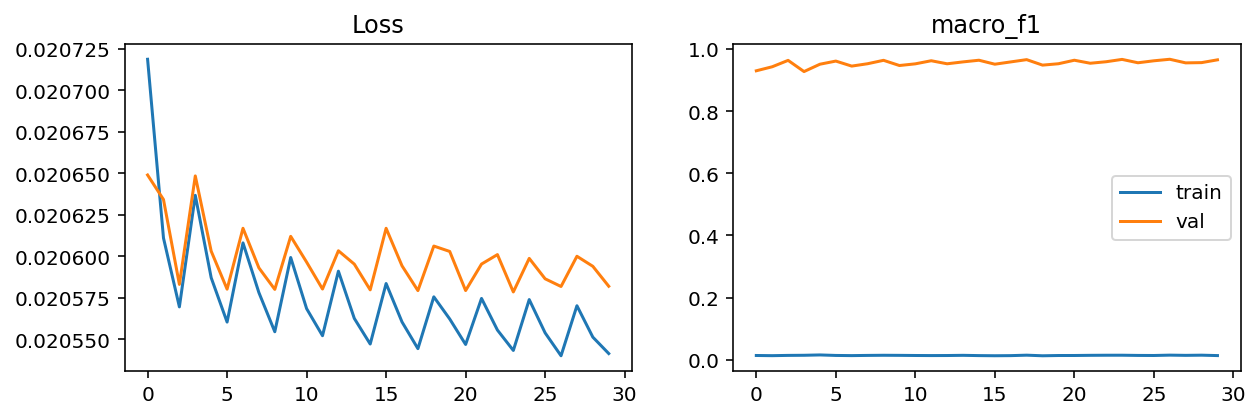

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      1.00      1.00       139
           2       1.00      0.99      1.00       311
           3       0.98      0.97      0.97       727
           4       0.81      0.89      0.85        65
           5       1.00      1.00      1.00       420
           6       0.96      1.00      0.98       273
           7       1.00      0.96      0.98       299
           8       1.00      0.99      0.99       413
           9       1.00      1.00      1.00       361
          10       1.00      1.00      1.00       142
          11       0.99      0.99      0.99       283
          12       1.00      1.00      1.00       125
          13       1.00      1.00      1.00        81
          14       0.99      0.99      0.99       125
          15       1.00      0.98      0.99       125
          16       1.00      1.00      1.00       125
          17       1.00    

In [ ]:
run(model = 'E', epoch= 30, batch_size = 32, optimizer='AdamW', memo = "Augmentation")

In [ ]:
models = [str(n) + 'th_model.pth' for n in range(5)]

import shutil

!mkdir /content/kfold3
for model in models:
    src = '/content/' + model
    dst = '/content/kfold3/' + model
    shutil.copy(src, dst)

# !mkdir /content/drive/MyDrive/4-1_Capstone/kfold
shutil.make_archive("/content/drive/MyDrive/4-1_Capstone/kfold/kfold3", "zip", "/content/kfold3")

In [14]:
from sklearn.model_selection import train_test_split
train_i, val_i, _, _ = train_test_split(list(range(len(label_df))), argmax_classes, stratify=argmax_classes, random_state=0)

train_images = np.array(images)[train_i]
val_images   = np.array(images)[val_i]

train_y = label_df[train_i]
val_y   = label_df[val_i]

In [15]:
def get_pred(model, val_dataset_info, batch_size = 32):

    test_loader = DataLoader(MyDataset(val_dataset_info, tf, split='VALIDATION'),
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=False,
                        pin_memory=True,
                        num_workers=4)

    preds = []

    model.eval()
    with torch.no_grad():
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)

            H = model(X)
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)

            preds.extend(H.detach().cpu().numpy().tolist())
    from sklearn.metrics import multilabel_confusion_matrix, classification_report

    # confusion_matrix = multilabel_confusion_matrix(val_y, (preds_numpy > 0).astype(float))

    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)

    cr = classification_report(val_dataset_info[1], preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(len(label_df.columns))])
    print(cr) # note_that support means count

    return preds

In [16]:
models = []
for i in range(5):
    model = timm.create_model(model_name = 'efficientnet_b0', pretrained=True)
    model.classifier = torch.nn.Linear(in_features=1280, out_features=N_CLASSES, bias=True)
    PATH = f"/content/{i}th_model.pth"
    model.load_state_dict(torch.load(PATH))
    model.eval().cuda()
    models.append(model)

In [17]:
val_dataset_info = (val_images, val_y)
preds = []
for i in range(5):
    pred = test(models[i], val_dataset_info, batch_size = 32)
    preds.append(pred)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       0.99      1.00      1.00       138
           2       1.00      1.00      1.00       311
           3       0.99      0.97      0.98       721
           4       0.99      0.94      0.97       207
           5       0.99      0.99      0.99       420
           6       0.95      1.00      0.97       272
           7       0.96      0.95      0.95       299
           8       0.99      0.98      0.98       413
           9       1.00      1.00      1.00       361
          10       0.99      1.00      1.00       142
          11       0.96      0.99      0.98       283
          12       0.98      1.00      0.99       125
          13       1.00      0.98      0.99        81
          14       1.00      0.98      0.99       125
          15       0.99      1.00      1.00       125
          16       1.00      1.00      1.00       125
          17       1.00    

In [19]:
from sklearn.ensemble import VotingClassifier
VC = VotingClassifier(
    estimators=[
    ('model0', models[0]), ('model1', models[1]), ('model2', models[2]), ('model3', models[3]), ('model4', models[4]),
    ],
    voting='soft'
)

pred_ensemble = np.zeros_like(preds[0])

for i in range(5):
    pred_ensemble += np.array(preds[i])

(pred_ensemble > 0) * 1

from sklearn.metrics import multilabel_confusion_matrix, classification_report

preds_numpy = np.array(pred_ensemble)
preds_sigmoid = (preds_numpy > 0).astype(float)

cr = classification_report(val_y, preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(72)])
print(cr) # note_that support means count

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      1.00      1.00       138
           2       1.00      1.00      1.00       311
           3       0.99      0.97      0.98       721
           4       0.98      0.97      0.97       207
           5       1.00      1.00      1.00       420
           6       0.99      1.00      0.99       272
           7       1.00      0.99      0.99       299
           8       1.00      1.00      1.00       413
           9       1.00      1.00      1.00       361
          10       1.00      1.00      1.00       142
          11       1.00      1.00      1.00       283
          12       1.00      1.00      1.00       125
          13       1.00      1.00      1.00        81
          14       1.00      0.99      1.00       125
          15       1.00      1.00      1.00       125
          16       1.00      1.00      1.00       125
          17       1.00    